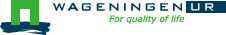



# Simulating with WOFOST 8.1 SNOMIN

This Jupyter notebook will introduce the WOFOST 8.1 module and its connection with the new multi-layer waterbalance and the SNOMIN C/N model. The new model components released with PCSE 6.0 present a major step in the ability to simulate complex rotation patterns and the carry-over effect of water, carbon and nitrogen within a crop rotation.

The PCSE WOFOST crop growth model has recently been extended to allow the simulation of nitrogen (N) limited growth (Berghuijs et al., 2024). The extensions of WOFOST included:
- Calculation of the daily crop N demand
- Calculation of the daily N uptake
- Calculation of the partition of nitrogen over the different organs.
- Calculation of translocation of N from vegetative organs (roots, stems, leaves) to the storage organs.

Under non-N growth limited growth conditions, these additions can be used to calculate N uptake by the crop and the N partitioning over the different organs. Non-N limited conditions imply that there is always enough available N in the soil to satisfy the daily crop N demand. However, the extensions above are not sufficient to simulate N uptake in case there is not enough N in the soil to satisfy the daily crop N demand. Therefore, a layered soil N module called SNOMIN (Soil Nitrogen module for Organic and MIneral Nitrogen) was developed and implemented in the PCSE framework (Berghuijs et al., 2024).

SNOMIN calculates the dynamics of organic and inorganic N (in the form of ammonium-N (${\mathrm{NH}_4}^{+}$) and nitrate-N (${\mathrm{NO}_3}^{+}$) in different soil layers. Since SNOMIN distinguishes different soil layers, it needs to be coupled to a layered soil water module to provide values for the soil moisture contents in each layer and of the water fluxes between adjacent layers. Since the classical waterbalance of PCSE does not distinguish different soil layers, SNOMIN cannot be coupled to this soil water module. Instead, WOFOST 8.1 and SNOMIN are in this example coupled to a new layered soil water module (Rappoldt et al, 2012). 

Other relevant extensions of WOFOST 8.1 are:
- Calculation of N deficiencies on crop growth
- Calculation of reallocation of dry matter from stem and leaves to storage organs.
- The maximum rate of gross (${\mathrm{CO}_2}^{+}$) assimilation is no longer a table function of the development stage (`AMAXTB` in WOFOST 7.2). Instead, the maximum rate of gross (${\mathrm{CO}_2}^{+}$) assimilation is calculated from the specific leaf N content.

These changes in WOFOST and the addition of a layered waterbalance and SNOMIN affect the input requirements for a simulation. The aim of this notebook is to:
1) Explain how inputs (crop, soil, site, agromanagement and weather) are obtained for a simulation where WOFOST 8.1, SNOMIN, and layered waterbalans are coupled.
2) Explain how a simulation can be run.
3) Visualize and explain the output

For this we will apply WOFOST8.1/SNOMIN for a potato crop in the Netherlands

Herman Berghuijs and Allard de Wit, June 2024

**Important notice**

This notebook contains many tables that explain the parameters required to run SNOMIN. Unfortunately, those tables do not render properly on github. Therefore, this notebook is best used from the jupyter-lab environment where they are represented properly.

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. PCSE 6.0 and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The `pandas` module for processing and storing WOFOST output;
  3. The `matplotlib` module for generating charts 


# 1. Importing the relevant modules

First the required modules need to be imported.

In [1]:
%matplotlib inline
import sys
from pathlib import Path

from IPython.display import Code
import yaml
import pandas as pd
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.input import YAMLCropDataProvider

print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

This notebook was built with:
python version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
PCSE version: 6.0.8


### Setting paths for I/O

In [2]:
data_dir = Path.cwd() / "data" / "wofost81"
input_dir = data_dir / "input"
crop_dir = input_dir / "crop"
output_dir = data_dir / "output"
sys.path.append(str(data_dir))

## 2. Obtaining input data 
### 2.1 Crop parameters
Crop parameters are read from YAML files. The collection of WOFOST YAML crop parameter files are [available on github](https://github.com/ajwdewit/wofost_crop_parameters). YAML files for different model version reside on different branches within the repository. However, for this notebook we will simply read the crop parameters from local files.

In [3]:
crop_dict = YAMLCropDataProvider(fpath=crop_dir)

### 2.2 Soil inputs

The soil module SNOMIN requires various input variables that are often defined per soil layer. The soil file contains all input variables that are not year-specific, This section will explain to combine these input variables in a dictionary and subsequently in a soil file that SNOMIN can read.

The modules SNOMIN and WaterbalanceLayered requires the following soil variables defined for the soil profile:

<div style="display: inline-block">
    
|Variable |Meaning| Unit|
|:-----|:-----|:---
|PFFieldCapacity|pF value of a soil layer at which its soil moisture content is at field capacity|log(cm $\mathrm{H}_{2}\mathrm{O}$)
|PFWiltingPoint|pF value of a soil layer at which its soil moisture content is at wilting point|log(cm $\mathrm{H}_{2}\mathrm{O}$)
|SurfaceConductivity|Hydraulic conductivity of the surface|$\mathrm{cm}$ $\mathrm{H}_{2}\mathrm{O}$ $\mathrm{s}^{-1}$|

</div>

We will define the values of these variables before

In [4]:
PFFieldCapacity = 2.0
PFWiltingPoint = 4.2
SurfaceConductivity = 75.

#### Layer properties

Moreover, SNOMIN and WATFDGW require values for the following 8 properties for each soil layer:

<div style="display: inline-block">
    
|Property |Meaning| Unit|
|:-----|:-----|:---
|Thickness|Soil layer thickness|cm|
|CNRatioSOMI|C:N ratio of organic matter|kg C $\mathrm{kg}^{-1}$  N|
|CRAIRC|Critical air content|$\mathrm{m}^{3}$ air $\mathrm{m}^{3}$ soil|
|FSOMI|Initial fraction of soil organic matter|kg OM $\mathrm{kg}^{-1}$ soil|
|RHOD|Bulk density|kg soil $\mathrm{m}^{-3}$ soil|
|Soil_pH|Soil pH|log(mol $\mathrm{H}^{+}$ $\mathrm{L}^{-1}$)|
|SMfromPF|Table function that describes the volumetric soil moisture content as a function of pF air content |$\mathrm{log}(\mathrm{cm}$ $\mathrm{H}_{2}\mathrm{O})$, $\mathrm{cm}^{3}$ $\mathrm{H}_{2}\mathrm{O}$ $\mathrm{cm}^{-3}$ soil|
|CONDfromPF|Table function that describes the 10-base logarithm as a function of pF air content|$\mathrm{log}(\mathrm{cm}$ $\mathrm{H}_{2}\mathrm{O})$, $\mathrm{log}(\mathrm{cm}$ $\mathrm{H}_{2}\mathrm{O}$ $\mathrm{s}^{-1})$|

</div>

The first 6 properties are **scalar** values, the last 2 are **tabular** properties which describe functional shapes. 

We will define the first 6 with the variables below as lists, where each list element contains the value of this property for a particular soil layer. In this case we will use four soil layers:

In [5]:
Thickness = [25., 15., 20., 60]
nlayers = len(Thickness)
CNRatioSOMI = [17., 25., 25., 25.]
CRAIRC = [0.09, 0.09, 0.09, 0.09]
FSOMI = [0.05, 0.02, 0.01, 0.]
RHOD = [1.375, 1.576, 1.633, 1.672]
SMW= [0.1,0.1,0.1,0.1] 
Soil_pH = [4.8, 4.5, 4.5, 4.7]

The distribution of these variables with soil depth is shown in the figures below. It demonstrates that the C:N-ratio of organic matter is lower in the upper layers, critical air content is assumed constant, while the fraction of organic matter strongly declines with depth. The bulk density is slightly lower in the upper layers (effect of ploughing) while the soil pH is effectively constant with depth.

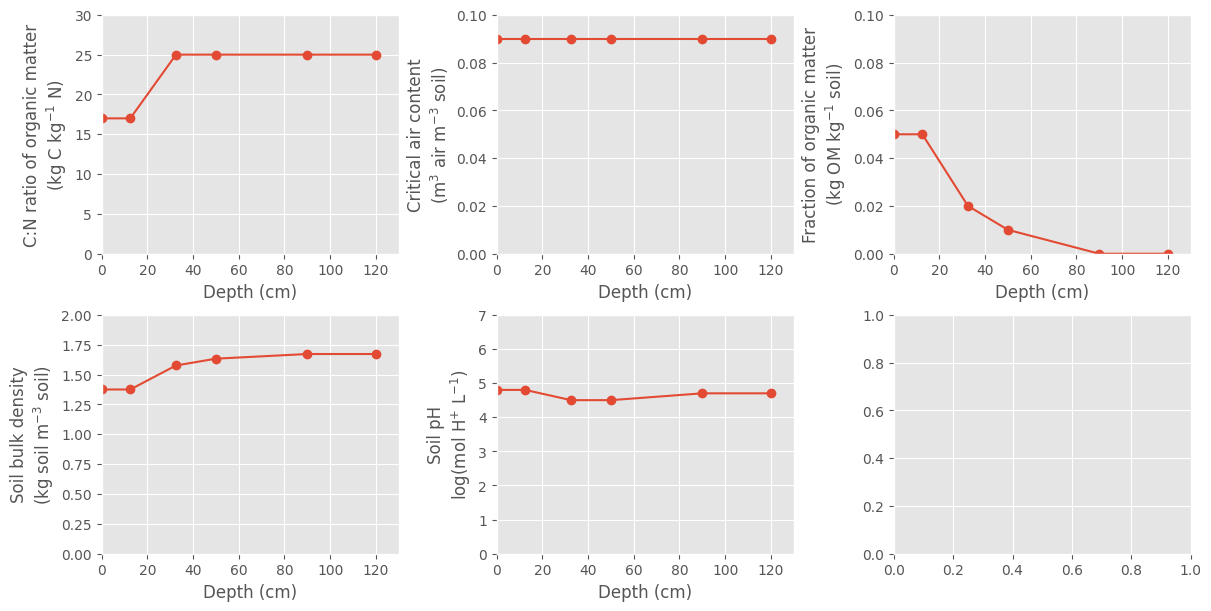

In [6]:
from w81_plotting import plot_SNOMIN_parameters
fig = plot_SNOMIN_parameters(Thickness, CNRatioSOMI, CRAIRC, FSOMI, RHOD, Soil_pH)

#### Hydraulic properties
Finally, two tabular parametes have to be defined that describe the soil moisture content (SM) and the 10-base logarithm of the hydraulic conductivity (COND) as a function of the hydraulic head (pF) for each soil layer.

One way to calculate the elements of the table functions *SMfromPF* and *CONDfromPF* is to obtain the *Van Genuchten* parameters *alpha*, *lambda*, *n*, *k_sat* (saturated hydraulic conductivity; cm d-1) and *theta_r* (residual soil moisture content) and *theta_s* (soil moisture content at saturation) and use them to calculate the values of SM and COND for various values of pF. These Van Genuchten parameters have to be specified for each soil layer:

In [7]:
alpha = [0.02164487, 0.01608317, 0.01608317, 0.01598691]
k_sat = [83.24163508, 22.76175599, 22.76175599, 22.32215442]
labda = [7.20207718, 2.43966226, 2.43966226, 2.8679672]
n = [1.34877009, 1.52441823, 1.52441823, 2.16275113]
theta_r = [0.02, 0.02, 0.02, 0.01]
theta_s = [0.43387803, 0.3870639, 0.3870639, 0.36584689]

We will calculate SMfromPF and CONDfromPF for the following pF values

In [8]:
pFs = [-1.0, 1.0, 1.3, 1.7, 2.0, 2.3, 2.4, 2.7, 3.0, 3.3, 3.7, 4.0, 4.2, 6.0]

The table function SMfromPF and CONDfromPF can now be constructed:

In [9]:
from vangenuchten import calculate_water_potential_form_pf, calculate_soil_moisture_content, calculate_log10_hydraulic_conductivity

CONDfromPF_perlayer = []
SMfromPF_perlayer = []

for i in range(nlayers):
    CONDfromPF = []
    SMfromPF = []
    for j, pF in enumerate(pFs):
        r = calculate_soil_moisture_content(pF, alpha[i], n[i], theta_r[i], theta_s[i])
        SMfromPF.extend([pF, r])
        r = calculate_log10_hydraulic_conductivity(pF, alpha[i], labda[i],k_sat[i], n[i])
        CONDfromPF.extend([pF, r])
    CONDfromPF_perlayer.append(CONDfromPF)
    SMfromPF_perlayer.append(SMfromPF)

The response functions of the soil moisture content to the pF in the different layers look like the figures below. It demonstrates that with increasing suction (pF) the amount of moisture in the soil decreases:

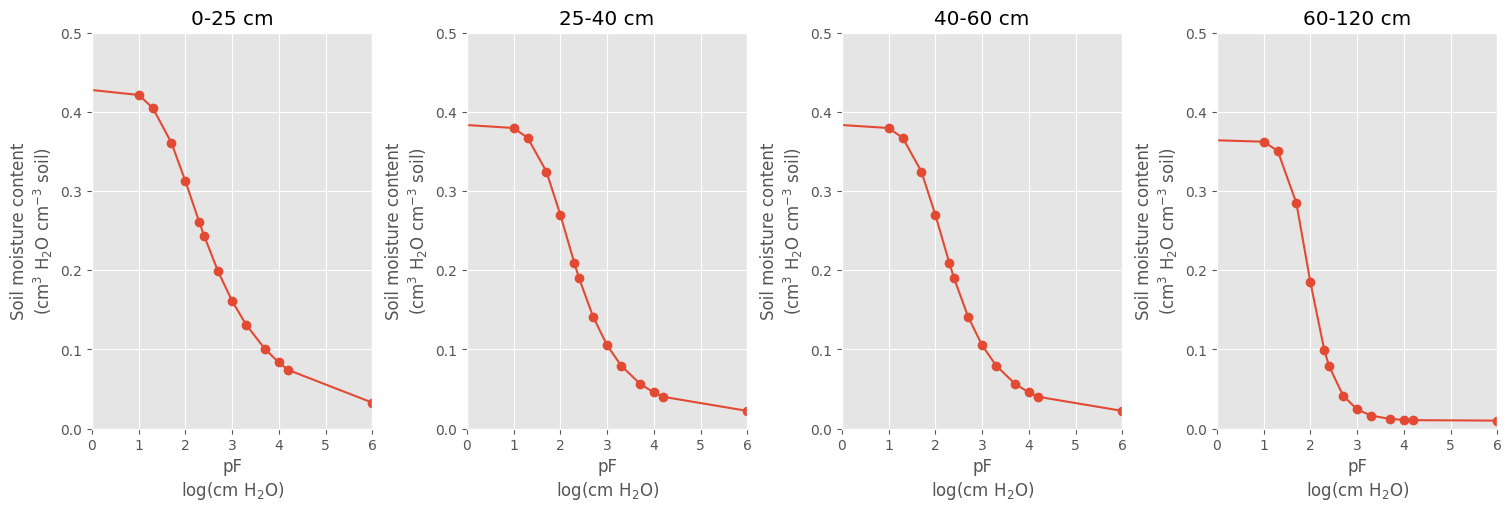

In [10]:
from w81_plotting import plot_pF_vs_soilmoisture
fig = plot_pF_vs_soilmoisture(SMfromPF_perlayer, Thickness, pFs)

And the response function of the 10-base logarithm to hydraulic conductivity to the pF looks like below. It clearly demonstrates that hydraulic conductivity is decreasing with increase pF values.:

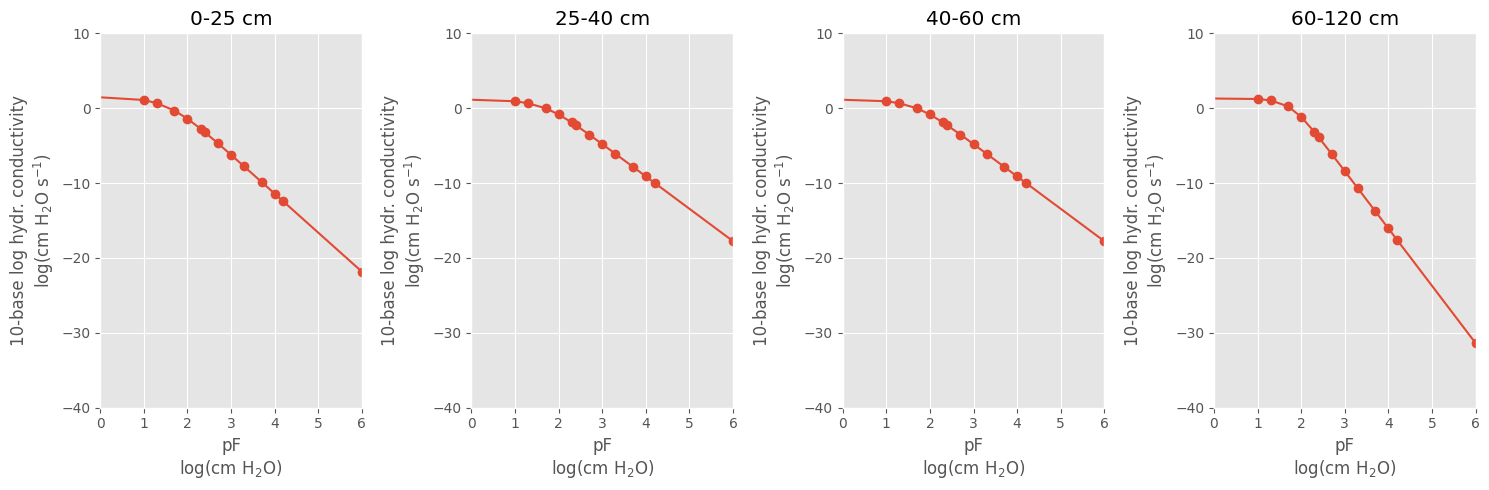

In [11]:
from w81_plotting import plot_pF_vs_conductivity
fig = plot_pF_vs_conductivity(CONDfromPF_perlayer, Thickness, pFs)

All information that is required to build a soil inputs is now available. We can now assemble everything into the right structure. We will use YAML to demonstrate the data structure:

In [12]:
from vangenuchten import make_string_table

# below we generate the header of the soil input file as YAML input structure # SMW:{sum(Thickness)}
soil_input_yaml = f"""
RDMSOL: {sum(Thickness)}

SoilProfileDescription:
    PFWiltingPoint: {PFWiltingPoint}
    PFFieldCapacity: {PFFieldCapacity}
    SurfaceConductivity: {SurfaceConductivity}
    GroundWater: false
    SoilLayers:
"""

# Here we generate the properties for each soil layer including layer thickness, hydraulic properties, 
# organic matter content, etc.
for i in range(nlayers):
    s = f"""    - Thickness: {Thickness[i]}
      CNRatioSOMI: {CNRatioSOMI[i]}
      CRAIRC: {CRAIRC[i]}
      FSOMI: {FSOMI[i]}
      RHOD: {RHOD[i]}
      
      Soil_pH: {Soil_pH[i]}
      SMfromPF: {make_string_table(SMfromPF_perlayer[i])}
      CONDfromPF: {make_string_table(CONDfromPF_perlayer[i])}
      SMW: {SMW[i]}
"""
    soil_input_yaml += s

# A SubSoilType needs to be defined. In this case we make the subsoil equal to the properties
# of the deepest soil layer.
soil_input_yaml += \
f"""    SubSoilType:
      CNRatioSOMI: {CNRatioSOMI[-1]}
      CRAIRC: {CRAIRC[-1]}
      FSOMI: {FSOMI[-1]}
      RHOD: {RHOD[-1]}
      
      Soil_pH: {Soil_pH[-1]}
      Thickness: {Thickness[-1]}
      SMfromPF: {make_string_table(SMfromPF_perlayer[-1])}
      CONDfromPF: {make_string_table(CONDfromPF_perlayer[i-1])}
      SMW: {SMW[-1]}
"""

# Parse YAML into a valid soil dict first
soil_dict = yaml.safe_load(soil_input_yaml)

# Print the soil input data structure
Code(soil_input_yaml, language="python")

RDMSOL: 120.0

SoilProfileDescription:
    PFWiltingPoint: 4.2
    PFFieldCapacity: 2.0
    SurfaceConductivity: 75.0
    GroundWater: false
    SoilLayers:
    - Thickness: 25.0
      CNRatioSOMI: 17.0
      CRAIRC: 0.09
      FSOMI: 0.05
      RHOD: 1.375
      
      Soil_pH: 4.8
      SMfromPF: [-1.0, 0.4339, 1.0, 0.4213, 1.3, 0.4050, 1.7, 0.3610, 2.0, 0.3124, 2.3, 0.2602, 2.4, 0.2436, 2.7, 0.1984, 3.0, 0.1611, 3.3, 0.1311, 3.7, 0.1007, 4.0, 0.0834, 4.2, 0.0740, 6.0, 0.0327, ]
      CONDfromPF: [-1.0, 1.8114, 1.0, 1.0935, 1.3, 0.6654, 1.7, -0.3195, 2.0, -1.4142, 2.3, -2.7413, 2.4, -3.2171, 2.7, -4.7014, 3.0, -6.2321, 3.3, -7.7821, 3.7, -9.8599, 4.0, -11.4212, 4.2, -12.4627, 6.0, -21.8391, ]
      SMW: 0.1
    - Thickness: 15.0
      CNRatioSOMI: 25.0
      CRAIRC: 0.09
      FSOMI: 0.02
      RHOD: 1.576
      
      Soil_pH: 4.5
      SMfromPF: [-1.0, 0.3871, 1.0, 0.3796, 1.3, 0.3671, 1.7, 0.3246, 2.0, 0.2697, 2.3, 0.2087, 2.4, 0.1898, 2.7, 0.1412, 3.0, 0.1051, 3.3, 0.0794, 3.7, 0.0567, 4.0, 0.0456, 4.2, 0.0401, 6.0, 0.0223, ]
      CONDfromPF: [-1.0, 1.3269, 1.0, 0.9261, 1.3, 0.6586, 1.7, -0.0142, 2.0, -0.8425, 2.3, -1.9102, 2.4, -2.3012, 2.7, -3.5313, 3.0, -4.8048, 3.3, -6.0944, 3.7, -7.8221, 4.0, -9.1198, 4.2, -9.9852, 6.0, -17.7758, ]
      SMW: 0.1
    - Thickness: 20.0
      CNRatioSOMI: 25.0
      CRAIRC: 0.09
      FSOMI: 0.01
      RHOD: 1.633
      
      Soil_pH: 4.5
      SMfromPF: [-1.0, 0.3871, 1.0, 0.3796, 1.3, 0.3671, 1.7, 0.3246, 2.0, 0.2697, 2.3, 0.2087, 2.4, 0.1898, 2.7, 0.1412, 3.0, 0.1051, 3.3, 0.0794, 3.7, 0.0567, 4.0, 0.0456, 4.2, 0.0401, 6.0, 0.0223, ]
      CONDfromPF: [-1.0, 1.3269, 1.0, 0.9261, 1.3, 0.6586, 1.7, -0.0142, 2.0, -0.8425, 2.3, -1.9102, 2.4, -2.3012, 2.7, -3.5313, 3.0, -4.8048, 3.3, -6.0944, 3.7, -7.8221, 4.0, -9.1198, 4.2, -9.9852, 6.0, -17.7758, ]
      SMW: 0.1
    - Thickness: 60
      CNRatioSOMI: 25.0
      CRAIRC: 0.09
      FSOMI: 0.0
      RHOD: 1.672
      
      Soil_pH: 4.7
      SMfromPF: [-1.0, 0.3658, 1.0, 0.3623, 1.3, 0.3507, 1.7, 0.2846, 2.0, 0.1846, 2.3, 0.0986, 2.4, 0.0789, 2.7, 0.0415, 3.0, 0.0242, 3.3, 0.0163, 3.7, 0.0122, 4.0, 0.0110, 4.2, 0.0106, 6.0, 0.0100, ]
      CONDfromPF: [-1.0, 1.3482, 1.0, 1.2277, 1.3, 1.0404, 1.7, 0.2378, 2.0, -1.1673, 2.3, -3.1540, 2.4, -3.8799, 2.7, -6.1281, 3.0, -8.4148, 3.3, -10.7102, 3.7, -13.7737, 4.0, -16.0717, 4.2, -17.6037, 6.0, -31.3921, ]
      SMW: 0.1
    SubSoilType:
      CNRatioSOMI: 25.0
      CRAIRC: 0.09
      FSOMI: 0.0
      RHOD: 1.672
      
      Soil_pH: 4.7
      Thickness: 60
      SMfromPF: [-1.0, 0.3658, 1.0, 0.3623, 1.3, 0.3507, 1.7, 0.2846, 2.0, 0.1846, 2.3, 0.0986, 2.4, 0.0789, 2.7, 0.0415, 3.0, 0.0242, 3.3, 0.0163, 3.7, 0.0122, 4.0, 0.0110, 4.2, 0.0106, 6.0, 0.0100, ]
      CONDfromPF: [-1.0, 1.3269, 1.0, 0.9261, 1.3, 0.6586, 1.7, -0.0142, 2.0, -0.8425, 2.3, -1.9102, 2.4, -2.3012, 2.7, -3.5313, 3.0, -4.8048, 3.3, -6.0944, 3.7, -7.8221, 4.0, -9.1198, 4.2, -9.9852, 6.0, -17.7758, ]
      SMW: 0.1

## 2.3 Specifying site parameters

The model WOFOST8.1/SNOMIN also requires site parameters that are specific for a given location. The site parameters in the table below are required by WOFOST81/SNOMIN and they are most easily specified through `pcse.input.WOFOST81SiteDataProvider_SNOMIN` which checks the ranges of all site parameters and provides sensible defaults. Note that the initial amount of NH4 and NO3 (*NH4I*, *NO3I*) must be provided for each soil layer as a list. 

<div style="display: inline-block">

|Variable |Meaning| Unit|
|:-----|:-----|:---
|A0SOM|The initial age of organic matter in the soil at the start of the simulation|year|
|CNRatioBio|C:N ratio of the microbial biomass|kg C $\mathrm{kg}^{-1}$ N|
|CO2|$\mathrm{CO}_2$ concentration in the ambient air|ppm|
|FASDIS|Ratio of assimilation to dissimilation rate|-|
|IFUNRN|Flag that indicates whether the infiltration fraction of non-infiltrating rainfall is fixed (0) or depends on the rainfall amount (1)|-|
|KDENIT_REF|Reference first-order dentrification rate|$\mathrm{d}^{-1}$|
|KNIT_REF|Reference first-order nitrification rate|$\mathrm{d}^{-1}$|
|KSORP|Sorption coefficient|$\mathrm{m}^{3}$ water $\mathrm{kg}^{-1}$ soil|
|MRCDIS|Michaelis-Menten constant of relationship organic C-dissimilation rate and response factor denitrification rate|$\mathrm{kg}$ C $\mathrm{m}^{-2}$ $\mathrm{d}^{-1}$|
|NH4ConcR|${\mathrm{NH}_4}^{+}$-N concentration in rain water|mg ${\mathrm{NH}_4}^{+}$-$\mathrm{N}$ $\mathrm{L}^{-1}$ water|
|NH4I|Initial amount of ${\mathrm{NH}_4}^{+}$-N per soil layer|kg ${\mathrm{NH}_4}^{+}$-$\mathrm{N}$ $\mathrm{ha}^{-1}$|
|NO3ConcR|${\mathrm{NO}_3}^{-}$-N concentration in rain water|mg ${\mathrm{NO}_3}^{-}$-$\mathrm{N}$ $\mathrm{L}^{-1}$ water|
|NO3I|Initial amount of ${\mathrm{NO}_3}^{-}$-N per soil layer|kg ${\mathrm{NO}_3}^{-}$-$\mathrm{N}$ $\mathrm{ha}^{-1}$|
|NOTINF|Maximum fraction of rainwater that cannot infiltrate the soil|$\mathrm{m}^{-3}$ water $\mathrm{m}^{-3}$ water|
|WFPS_CRIT|Critical fraction of pores that is filled with water|$\mathrm{m}^{-3}$ water $\mathrm{m}^{-3}$ soil|
|SMLIM|Maximum initial soil moisture content in top soil|$\mathrm{m}^{-3}$ water $\mathrm{m}^{-3}$ soil|
|SSI|Initial amount of water in surface storage|cm water|
|SSMAX|Maximum amount of water in surface storage|cm water|
|WAV|Initial amount of available water|cm water|

</div>


In [13]:
from pcse.input import WOFOST81SiteDataProvider_SNOMIN
site_dict = WOFOST81SiteDataProvider_SNOMIN(A0SOM=24.0,
                                            CNRatioBio=9.0,
                                            CO2=400.,
                                            FASDIS=0.5,
                                            IFUNRN=0,
                                            KDENIT_REF=0.06,
                                            KNIT_REF=1.0,
                                            KSORP=0.0005,
                                            MRCDIS=0.001,
                                            NH4ConcR=1.0,
                                            NH4I=[5., 0., 0., 0.],
                                            NO3ConcR=4.0,
                                            NO3I=[30., 0., 0., 0.],
                                            NOTINF=1.0,
                                            WFPS_CRIT=0.8,
                                            SMLIM=0.31,
                                            SSI=0.,
                                            SSMAX=0.,
                                            WAV=30.,
                                            )

### 2.4 Agromanagement files
The setup of the Agromanagement files is similar to the setup of agromanagement files that were used in previous versions of PCSE. The difference is that it is also possible to define nitrogen fertilization events for SNONIN (through the `apply_n_snomin` timed events). For each application event, an application date needs to be provided. Furthermore, the following information about the amendment needs to be provided per fertilization event:

<div style="display: inline-block">

|Variable |Meaning| Unit|
|:-----|:-----|:---
|amount|Amount of applied amendment|$\mathrm{kg}$ amendment $\mathrm{ha}^{-1}$ 
|application_depth|Depth over which the amendment is applied|cm
|cnratio|Initial C:N ratio of applied material|$\mathrm{kg}$ C $\mathrm{kg}^{-1}$ N
|f_NH4N|Weight fraction of $\mathrm{NH}_4^{+}$-$\mathrm{N}$|$\mathrm{kg}$ $\mathrm{NH}_4^{+}$-$\mathrm{N}$ $\mathrm{kg}^{-1}$ amendment
|f_NO3N|Weight fraction of $\mathrm{NO}_3^{-}$-$\mathrm{N}$|$\mathrm{kg}$ $\mathrm{NO}_3^{-}$-$\mathrm{N}$ $\mathrm{kg}^{-1}$ amendment
|initial_age|Initial age of amendment|year
|f_orgmat|Fraction of organic matter in amendment|$\mathrm{kg}$ OM $\mathrm{kg}^{-1}$ amendment

</div>

If the amendment consists of a synthetic fertilizer, `f_orgmat` needs to be set equal to 0. The property `initial_age` can be set to 0 (or any other value). If the amendment is applied at the surface, the variable `application_depth` can be set to 0.

Part of the agromanagement definition is shown below which defines three fertilization events with mineral fertilizers which is typical for a potato crop in the Netherlands. However, the actual agromanagement definition which is used for the simulation is more complex as contains many small irrigation events to simulate the impact of drip irrigation (not shown here). 

In [14]:
from pcse.input import YAMLAgroManagementReader
agro_dir = input_dir / "agro"
agro_fname = agro_dir / "example_agro.yaml"
agro_dict = YAMLAgroManagementReader(agro_fname)

### 2.5 Weather data
The weather data formats that WOFOST 8.1, SNOMIN, and the new layered water balance module use have not changed compared to WOFOST 7.2. The weather data are loaded as:

In [15]:
from pcse.input import ExcelWeatherDataProvider
weather_dir = input_dir / "weather"
weather_fname = weather_dir / "example_weather.xlsx"
wdp = ExcelWeatherDataProvider(weather_fname)

## 3.Running a simulation
All model input is now collected. The next step is to combine the model input into a single parameter object


In [16]:
from pcse.base import ParameterProvider
parameters = ParameterProvider(sitedata=site_dict, soildata = soil_dict, cropdata=crop_dict)

The parameter object is now used to make a simulation object and run the model.

In [17]:
from pcse.models import Wofost81_NWLP_MLWB_SNOMIN
conf_file = Path.cwd() / "conf" / "Wofost81_NWLP_MLWB_SNOMIN.conf"
# conf=
wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict,config=conf_file)
wofost.run_till_terminate()
df_output = pd.DataFrame(wofost.get_output())

output_fp = output_dir / "example_output.xlsx"
df_output.to_excel(output_fp)

In [18]:
# from pcse.models import Wofost81_NWLP_MLWB_SNOMIN
# conf_file = Path.cwd() / "conf" / "Wofost81_NWLP_CWB_CNB.conf"
# # conf=
# wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict,config=conf_file)
# wofost.run_till_terminate()
# df_output = pd.DataFrame(wofost.get_output())

# output_fp = output_dir / "example_output_NWLP_CWB_CNB.xlsx"
# df_output.to_excel(output_fp)

KeyError: 'SMW'

## 3 Visualize output
All state variables in WOFOST 7.2 are also present in WOFOST 8.1. For instance, we can plot the total dry matter, tuber dry weight and leaf area index:

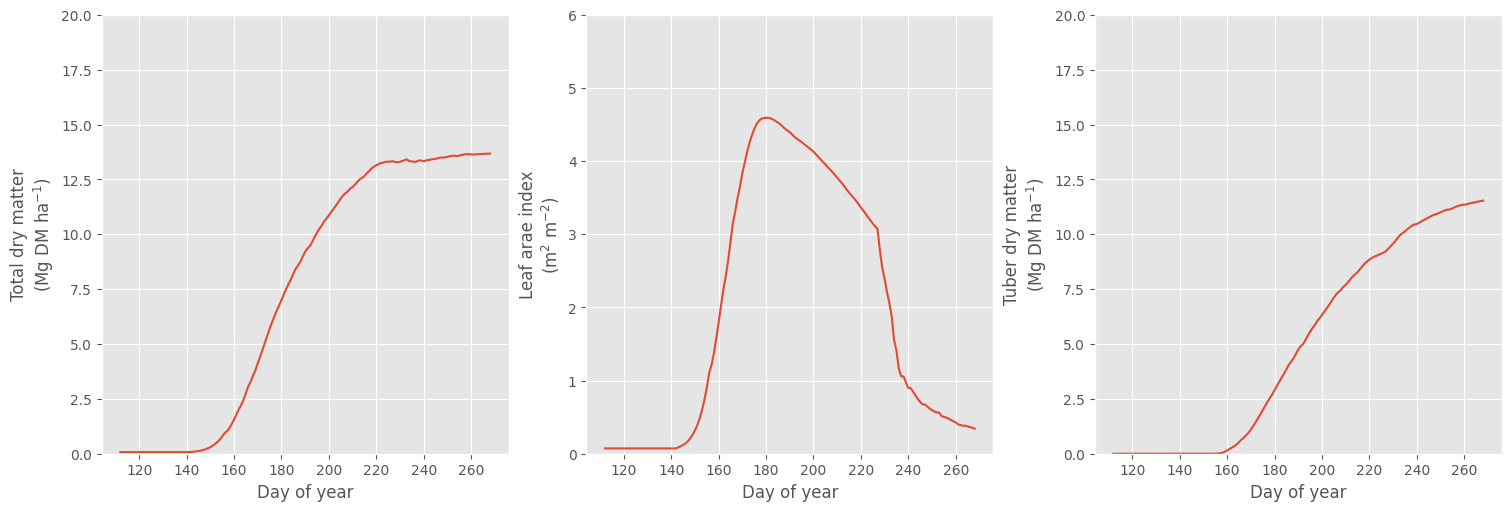

In [19]:
from w81_plotting import plot_w72_variables
fig = plot_w72_variables(df_output)

Finally, the addition of SNOMIN and the layered waterbalance also introduced various layer specific state variable. These are the soil moisture contents, the amounts of ammonium-N and the amounts of nitrogen-N per soil layer (see below). 

The figure for the NH4 amount in the top layers starts at 5 kg/ha (actually the value of NH4I in the site parameters) and then rapidly increases to around 70 kg/ha due to a fertilization event. The amount of NO3 starts at 30 kg/ha (parameter NO3I) and then rapidly increases to 90 kg/ha due to fertilization. Next, the amount of NH4 rapid decreases due to the conversion of NH4 to NO3 (nitrification) and consequently the amount of NO3 increases. This patterns repeats itself for a second fertilization event around day 125.

From day 150 onward the potato crop starts taking up N rapidly leading to steap decrease in N availability. A final fertilizer event around day 170 then adds some NO3/NH4 but the total N amount is rapidly depleated until day 260 when the crop cycle is finished. 

In this example, the crop is able to take up all N from the soil with little leaching of N towards lower layers.

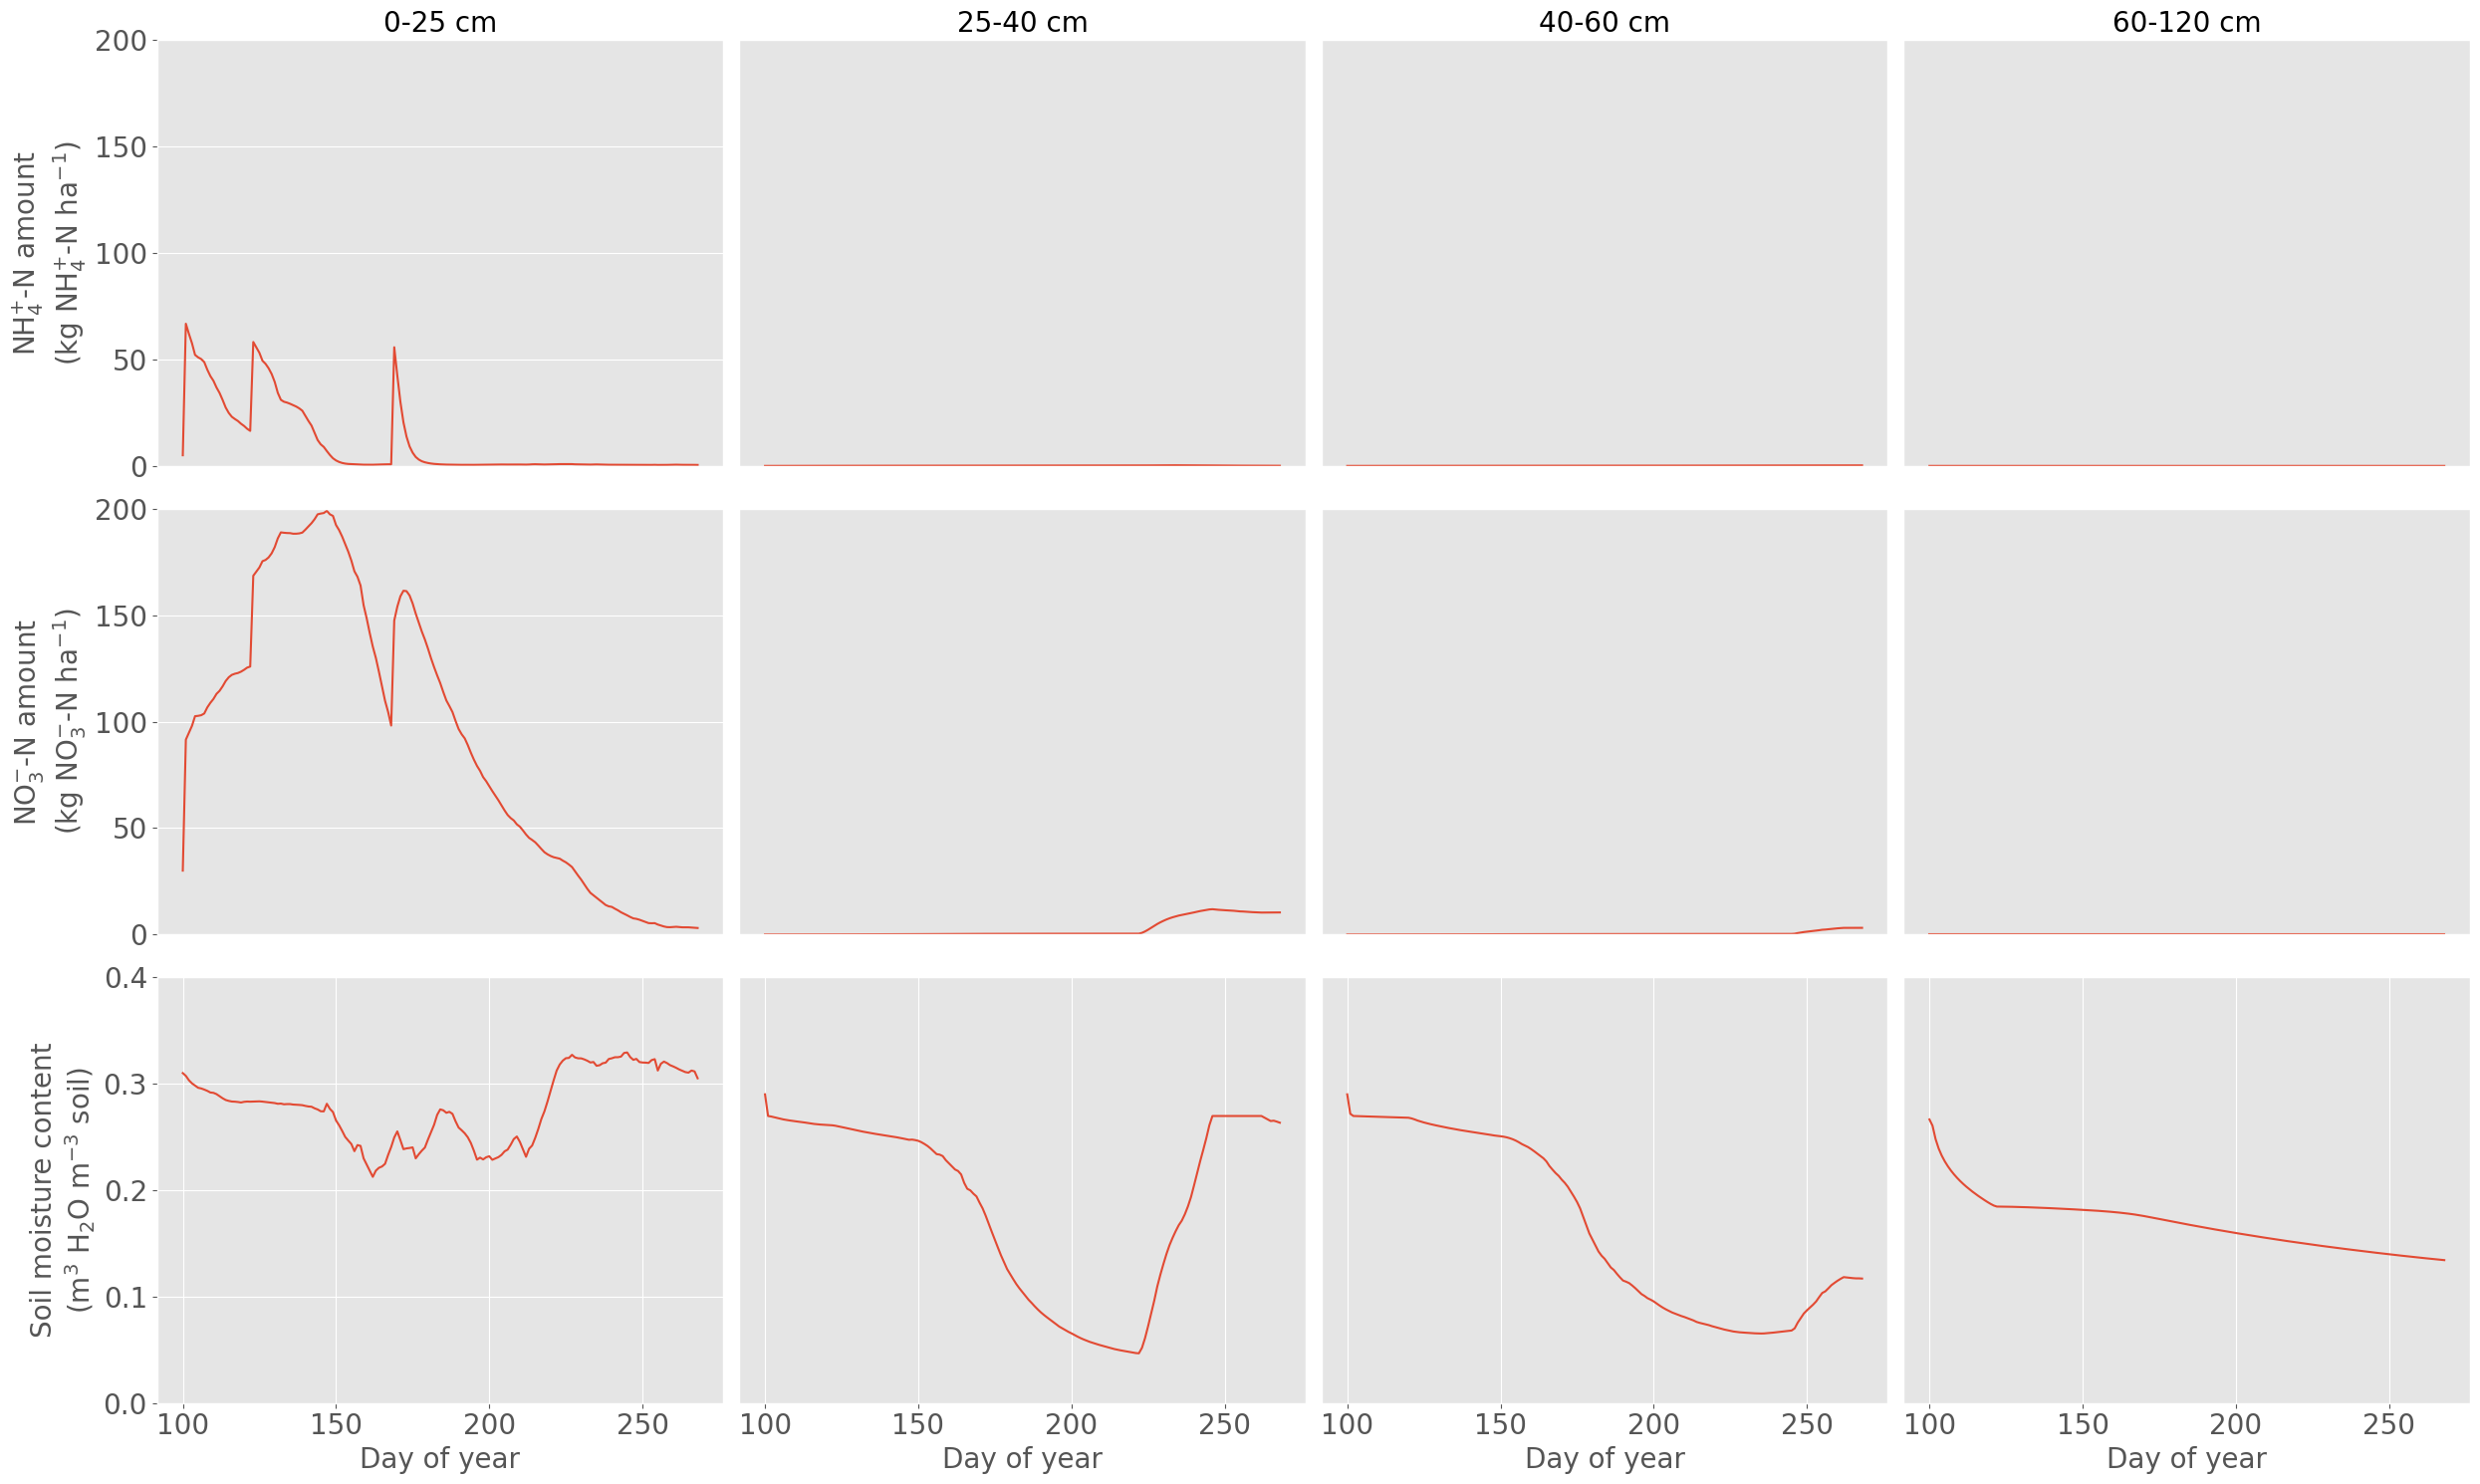

In [20]:
from w81_plotting import plot_w81_soil_variables
fig = plot_w81_soil_variables(df_output, Thickness)

In addition, various state variables have been added to WOFOST 8.1 that describe the N state of the crop. For instance, WOFOST 8.1 is now capable of simulating the amount of N in crop organs:

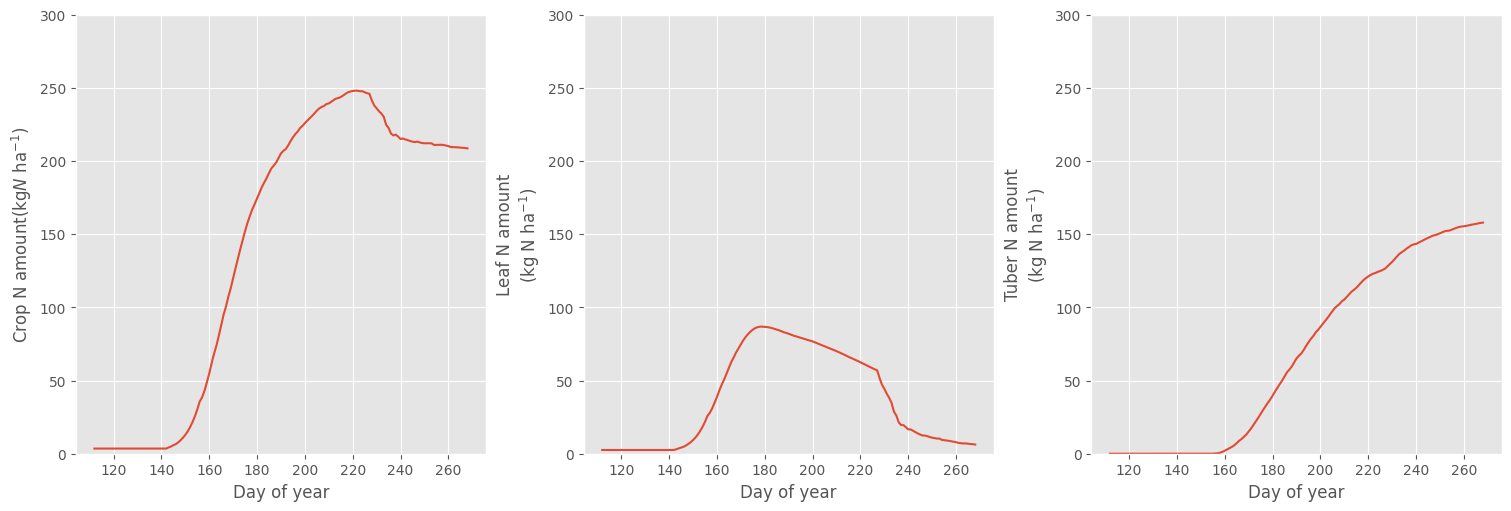

In [21]:
from w81_plotting import plot_w81_crop_variables
fig = plot_w81_crop_variables(df_output)

And the total amounts of $\mathrm{NH}_4^{+}$-$\mathrm{N}$, $\mathrm{kg}$ $\mathrm{NO}_3^{-}$-$\mathrm{N}$, and water are shown below. Given that most of the N remains in the upper layers, the figure for NO3/NH4 below are similar to the figures already shown for layer 1.

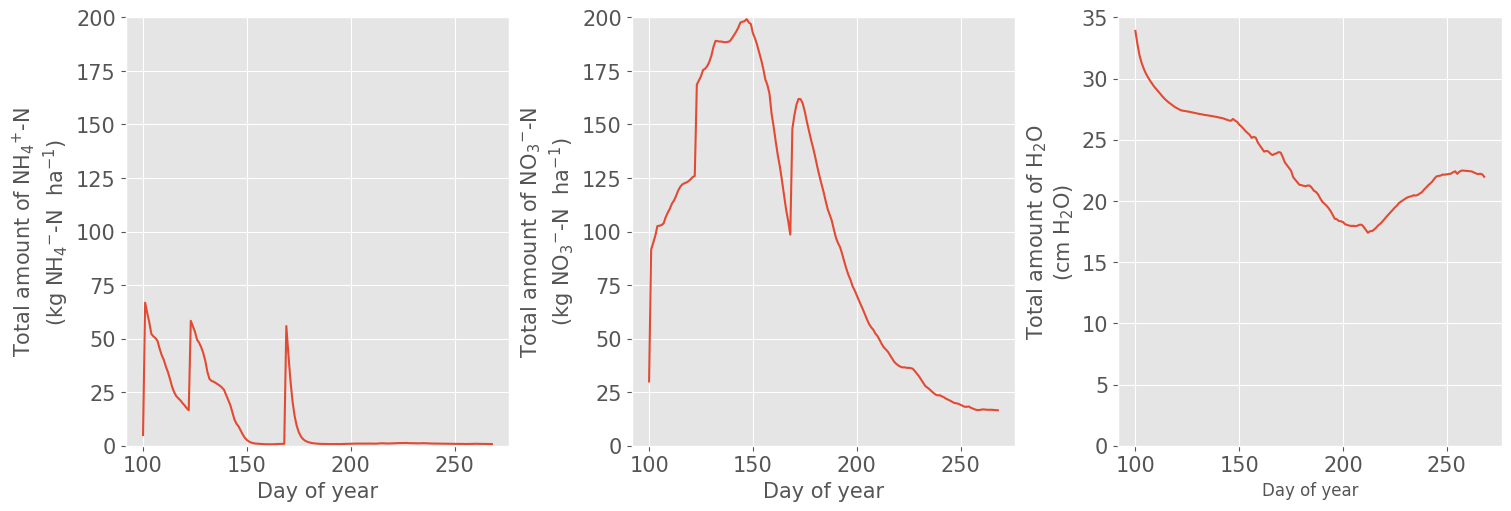

In [22]:
from w81_plotting import plot_w81_soil_totals
fig = plot_w81_soil_totals(df_output, Thickness, nlayers)

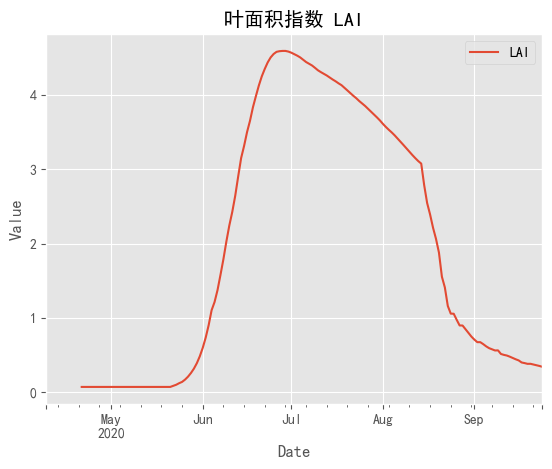

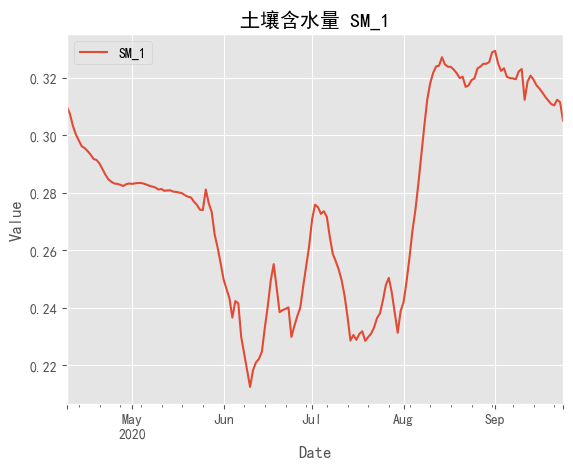

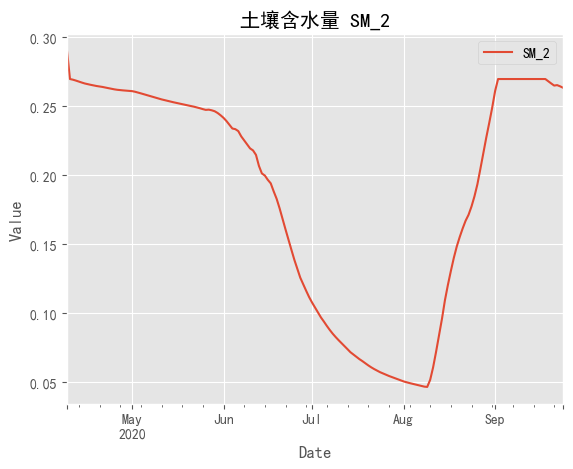

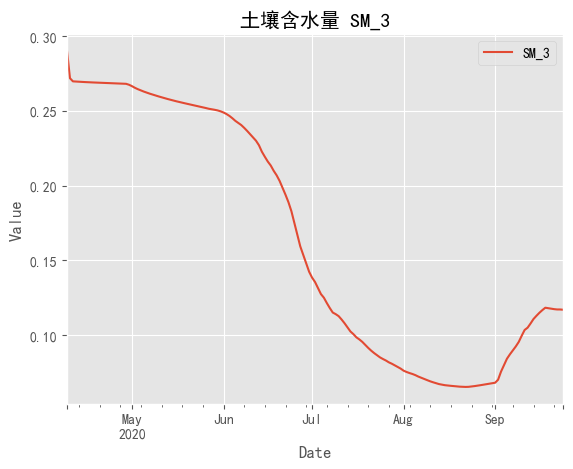

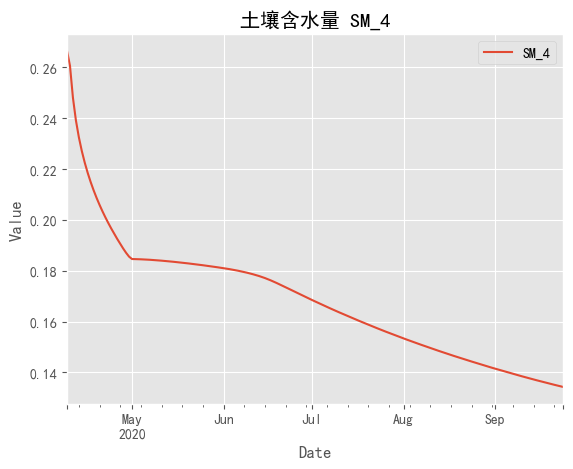

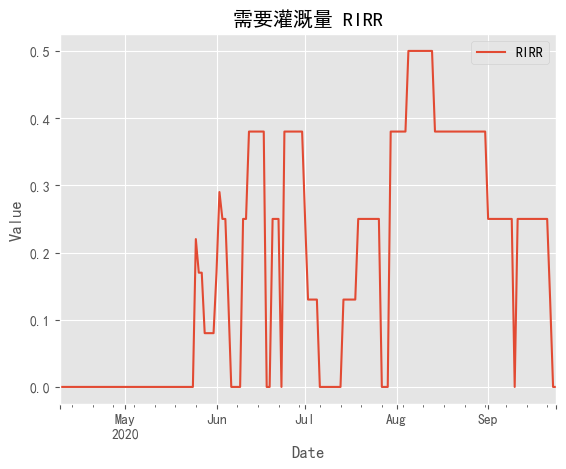

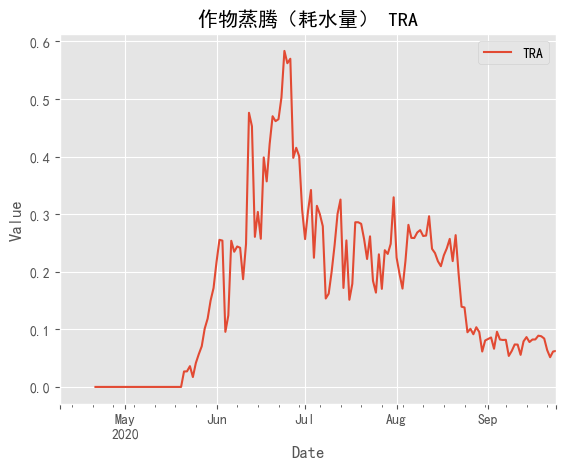

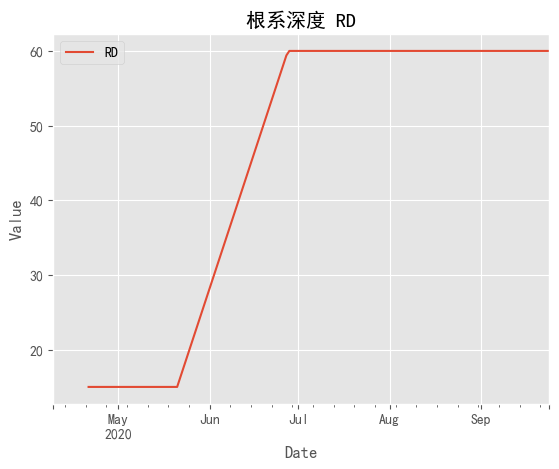

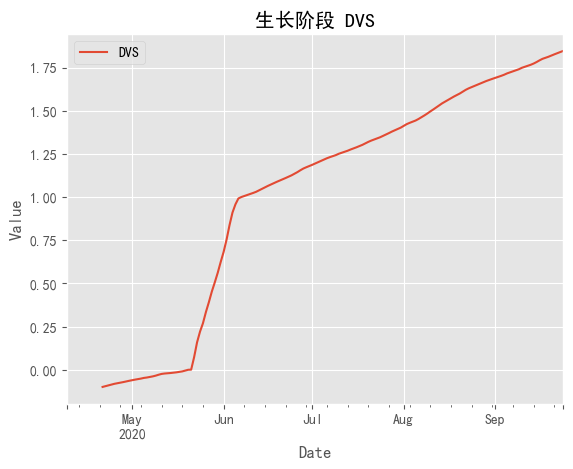

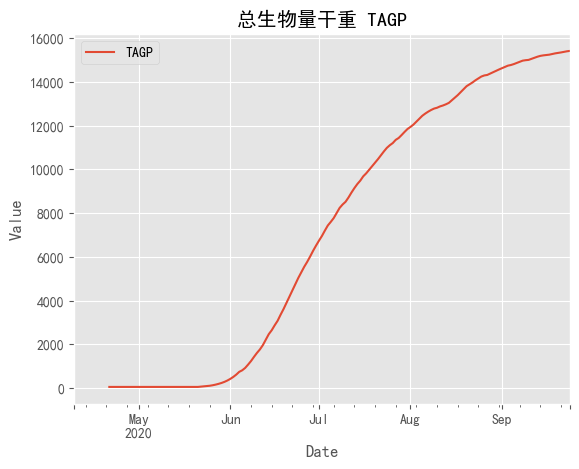

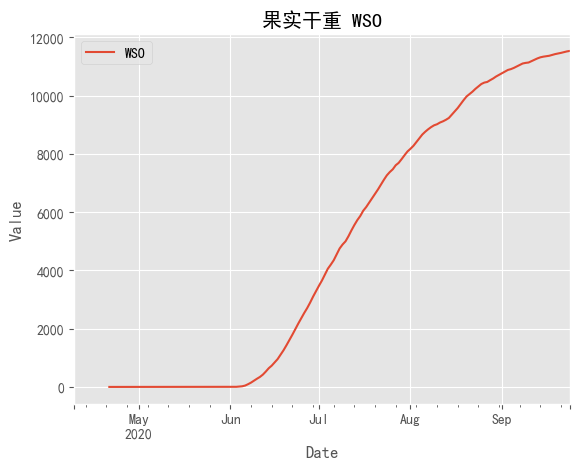

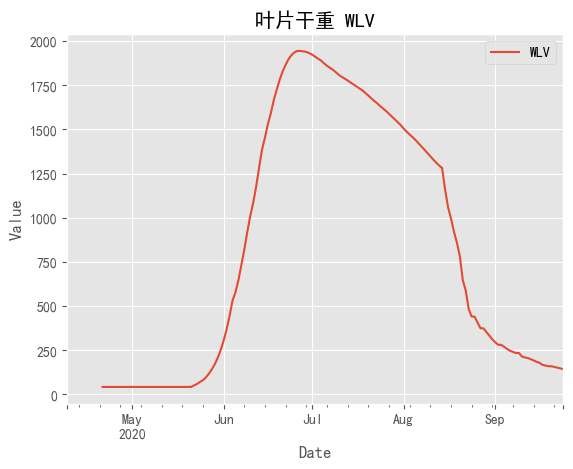

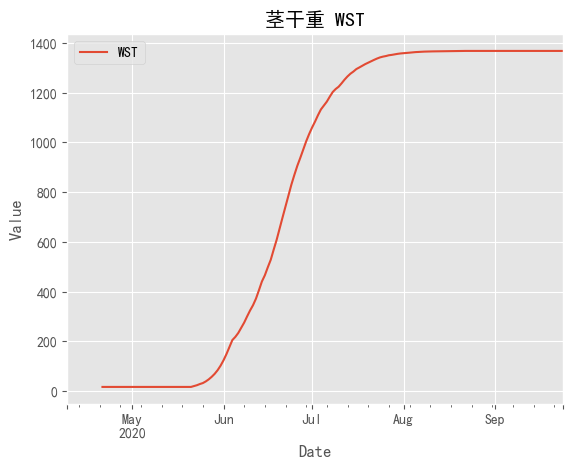

In [32]:
# print(df_output.tail())


# df_output('SM')
# 绘图  
# 设置中文字体为黑体，可根据实际情况替换为其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False
ax = df_output.plot(x='day', y='LAI', title="叶面积指数 LAI", ylabel="Value", xlabel="Date")
ax = df_output.plot(x='day', y='SM_1', title="土壤含水量 SM_1", ylabel="Value", xlabel="Date")
ax = df_output.plot(x='day', y='SM_2', title="土壤含水量 SM_2", ylabel="Value", xlabel="Date")
ax = df_output.plot(x='day', y='SM_3', title="土壤含水量 SM_3", ylabel="Value", xlabel="Date")
ax = df_output.plot(x='day', y='SM_4', title="土壤含水量 SM_4", ylabel="Value", xlabel="Date")

ax = df_output.plot(x='day', y='RIRR', title="需要灌溉量 RIRR", ylabel="Value", xlabel="Date")
# ax = df_output.plot(x='day', y='TOTIRR', title="总灌溉量 TOTIRR", ylabel="Value", xlabel="Date")
# ax = df_output.plot(x='day', y='IRRIG', title="灌溉量 IRRIG", ylabel="Value", xlabel="Date")
# ax = df_output.plot(x='day', y='WBOT', title="渗漏量 WBOT", ylabel="Value", xlabel="Date")
# WBOT, Water below maximum rootable depth and unavailable for plant growth.

ax = df_output.plot(x='day', y='TRA', title="作物蒸腾（耗水量） TRA", ylabel="Value", xlabel="Date")
ax = df_output.plot(x='day', y='RD', title="根系深度 RD", ylabel="Value", xlabel="Date")

ax = df_output.plot(x='day', y='DVS', title="生长阶段 DVS", ylabel="Value", xlabel="Date")

ax = df_output.plot(x='day', y='TAGP', title="总生物量干重 TAGP", ylabel="Value", xlabel="Date")
# ax = df_output.plot(x='day', y='TWSO', title="果实干重 TWSO", ylabel="Value", xlabel="Date")
# ax = df_output.plot(x='day', y='TWLV', title="叶片干重 TWLV", ylabel="Value", xlabel="Date")
# ax = df_output.plot(x='day', y='TWST', title="茎干重 TWST", ylabel="Value", xlabel="Date")

ax = df_output.plot(x='day', y='WSO', title="果实干重 WSO", ylabel="Value", xlabel="Date")
ax = df_output.plot(x='day', y='WLV', title="叶片干重 WLV", ylabel="Value", xlabel="Date")
ax = df_output.plot(x='day', y='WST', title="茎干重 WST", ylabel="Value", xlabel="Date")


In [34]:
print(df_output['SM'][0][0])
print(df_output['SM'].tail())

print(df_output.tail())

# ax = df_output['SM'].plot(x='day', y='SM', title="土壤含水量 SM", ylabel="Value", xlabel="Date")

0.31
164    [0.3109241342412099, 0.26648200758845125, 0.11...
165    [0.3104299495652547, 0.2649665103060653, 0.117...
166    [0.3124, 0.265283117844827, 0.1171491920867763...
167    [0.31158203488533875, 0.2644234395925905, 0.11...
168    [0.3051137134449398, 0.2633952903151761, 0.116...
Name: SM, dtype: object
           day       DVS       LAI          TAGP           WSO         WLV  \
164 2020-09-20  1.819690  0.383453  15319.652643  11443.255465  159.772014   
165 2020-09-21  1.826476  0.374244  15342.720313  11465.631106  155.935108   
166 2020-09-22  1.833214  0.364764  15369.406573  11491.516778  151.985011   
167 2020-09-23  1.839810  0.354692  15394.943764  11516.287853  147.788398   
168 2020-09-24  1.846381  0.343278  15411.745595  11532.585630  143.032434   

             WST         WRT    RD  \
164  1368.046319  687.288719  60.0   
165  1368.046319  673.542945  60.0   
166  1368.046319  660.072086  60.0   
167  1368.046319  646.870644  60.0   
168  1368.046319  633.93323